# K-Nearest Neighbors

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.knn import KNN_model
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import src.utils as utils

### Without outliers

In [2]:
df = pd.read_csv('data/diamonds.csv')
X_train, X_test, y_train, y_test = utils.preprocessing_LOS(df)

Let's train KNN using the parameters that go by default in the model and observe the score we get on a validation set created from splitting our data.

In [3]:
# Splitting the data into train and validation sets
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# KNN
knn = KNN_model(n_neighbors=5, leaf_size=30)
knn.cross_validation(X_train, y_train, 5, 0.2)

Performing cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Cross validation (accuracy) scores:
	mean: 0.6587569133526467 std: 0.002464406123842946


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.3s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


There is a way to improve this score, for starters, `n_neighbors` should be higher given that we have high dimensional data.

We can compute **grid search** and try to identify which value is best setting an initial range of values (1,20).

In [5]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(1, 20)}  # Set a range for the hyperparameter n_neighbors to try

knn = KNN_model(algorithm = 'auto') # Create the model to use for hyperparameter tuning
grid_search = GridSearchCV(knn, param_grid, cv=5)  # Adjust the cv parameter as needed for cross-validation

grid_search.fit(X_train, y_train)  # Fit the hyperparameter search model

# Retrieve the best parameter value
best_n_neighbors = grid_search.best_params_['n_neighbors']
print("Best value for n_neighbors:", best_n_neighbors, "with score:", grid_search.best_score_)



Best value for n_neighbors: 19 with score: 0.6955331659349273


Let's now see how it performs on our validation set.

In [7]:
best_model = KNN_model(n_neighbors=best_n_neighbors)
best_model.fit(X_train2, y_train2)
best_model.compute_metrics(X_val, y_val)

{'accuracy': 0.6839610218593627,
 'precision': 0.5074065645069263,
 'recall': 0.49236287112300514,
 'f1': 0.49149332993266165}

How can we increase this accuracy?

1. Try to set the parameter `p` (metric used) to 1 so that we apply manhattan since we have somewhat high-dimensional data
2. See if changing the `weighting` method has any effect on the accuracy of the model
3. Apply a broader range for `n_neighbors` to have more simplicity (reducing overfitting) since our data is high-dimensional, and have a random          value for the variable for every iteration to speed up computation.

In order to perform that we apply a randomized search specifying a parameter grid with the mentioned above factors.

In [8]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': randint(1, 45),  # Range of values for n_neighbors
    'weights': ['uniform', 'distance'],  # Weighting method
    'p': [1, 2]  # Power parameter for Minkowski distance (1 for Manhattan, 2 for Euclidean)
}

knn = KNN_model(algorithm = 'auto') # Create the model to use for hyperparameter tuning
knn_random = RandomizedSearchCV(knn, param_distributions=param_grid, n_iter = 30, cv = 5, random_state = 42)  # Define the random search model
knn_random.fit(X_train, y_train)  # Fit the random search model

# Retrieve the best hyperparameters
best_params = knn_random.best_params_
print("Best hyperparameters:", best_params)

best_score = knn_random.best_score_
print("Best score:", best_score)

Best hyperparameters: {'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}
Best score: 0.7016436447900306


In [11]:
knn = KNN_model(**best_params)  # Create a new model with the best parameters
knn.fit(X_train2, y_train2)  # Fit this model to the data
knn.compute_metrics(X_val, y_val)  # Compute the metrics for this model

c:\Users\pikur\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pikur\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pikur\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.6908085330524097,
 'precision': 0.5191093244107648,
 'recall': 0.49262267271764515,
 'f1': 0.49440510690676664}

We see in the warnings that the model didn't make predictions for some classes. Moreover, hyperparameter tuning beyond just `n_neighbors` doesn't seem to have a large increment to the accuracy in our model.

We conclude that using **Manhattan** as a metric is needed for our problem due to high dimensionality and that the weighting method needs to be uniform.
However, `n_neighbors` remains a variable that we can still somehow manipulate manually in order to get a higher score.

Let's try for k in {25, 30, 35, 40, 45, 50, 55, 60, 65, 70}, considering that our actual best is 25 so that we can compare.

In [83]:
import prettytable as pt # Visualize the results in a pretty table

k_list = [25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
table = pt.PrettyTable()
table.field_names = ["K-Value", "Accuracy"]

for k in k_list:
    knn = KNN_model(n_neighbors=k, algorithm='auto', weights='uniform', p=1)
    knn.fit(X_train2, y_train2)
    score = knn.score(X_val, y_val)
    table.add_row([k, score])

print(table)

+---------+--------------------+
| K-Value |      Accuracy      |
+---------+--------------------+
|    25   | 0.6969457609268036 |
|    30   |  0.69971037388099  |
|    35   | 0.7003686150605581 |
|    40   | 0.6998420221169036 |
|    45   | 0.6965508162190627 |
|    50   | 0.6961558715113217 |
|    55   | 0.6957609268035808 |
|    60   |  0.69681411269089  |
|    65   | 0.6965508162190627 |
|    70   | 0.6977356503422855 |
+---------+--------------------+


The best model is the one with 35 `n_neighbors`, with an accuracy of 0.7 approx.

In [14]:
knn = KNN_model(n_neighbors=35, algorithm = 'auto', weights = 'uniform', p = 1)
knn.fit(X_train2, y_train2)
score = knn.score(X_val, y_val)
print(f"Accuracy:", score)

Accuracy: 0.6951540690018435


In conclusion, hyperparameter tuning in the KNearestNeighbors algorithm doesn't seem to be as effective as setting a predefined range of values for the parameter `n_neighbors`. The model is able to get a decent accuracy. However, the rest of the metrics need to be computed in order to evaluate its performance.

In [15]:
knn.compute_metrics(X_val, y_val) # Using our own function to compute the metrics

c:\Users\pikur\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pikur\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pikur\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.6951540690018435,
 'precision': 0.5277236856042737,
 'recall': 0.4921570953562213,
 'f1': 0.49509050971378565}

The **precision** and **accuracy** seem to be closer to each other in value than with recall, implying that the model is making correct predictions overall at a rate comparable to the rate of correct predictions within the positive predictions. 

Nevertheless, the **recall** and **f1 scores** are low implying that KNN doesn't generalize well in this particular problem.

As we can see in the following code, setting a lower value for `n_neighbors` in the algorithm does make a small improvement in generalization by improving recall and f1, but it decreases accuracy.

In [16]:
knn = KNN_model(n_neighbors=5, algorithm = 'auto', weights = 'uniform', p = 1)
knn.fit(X_train, y_train)
score = knn.score(X_test, y_test)
knn.compute_metrics(X_test, y_test) # Using our own function to compute the metrics

{'accuracy': 0.672039612305099,
 'precision': 0.6152687680512579,
 'recall': 0.5453912391234756,
 'f1': 0.5676566225488396}

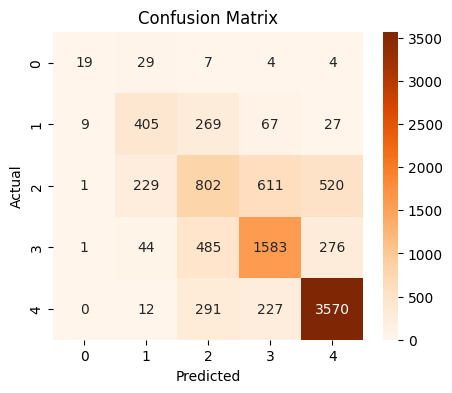

In [17]:
conf_matrix = knn.conf_matrix(X_test, y_test)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()